# Classification Workflow with Pipelines

Let's add pipelines into our workflow!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipe

from src.model_handling import ModelStorer, ModelWithCV, SaveModel

from datetime import datetime

In [2]:
df = pd.read_csv('./data/default.csv', header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

Gender (1 = male; 2 = female).

Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

Marital status (1 = married; 2 = single; 3 = others).

Age (year).

History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
- PAY_0 = the repayment status in September, 2005
- PAY_1 = the repayment status in August, 2005 . . .
- PAY_6 = the repayment status in April, 2005 

The measurement scale for the repayment status is: 
- -1 = pay ontime; 
- 1 = payment delay for one month
- 2 = payment delay for two months
- 8 = payment delay for eight months
- 9 = payment delay for nine months and above.

Amount of bill statement. 
- BILL_AMT1 = amount of bill statement in September, 2005
- BILL_AMT2 = amount of bill statement in August, 2005 . . .
- BILL_AMT6 = amount of bill statement in April, 2005

Amount of previous payment. 
- PAY_AMT1 = amount paid in September, 2005 
- PAY_AMT2 = amount paid in August, 2005 . . .
- PAY_AMT6 = amount paid in April, 2005



In [4]:
df.drop('ID', axis=1, inplace=True)

In [5]:
df.rename(columns = {'default payment next month':'default'}, inplace=True)

In [6]:
df.columns = [x.strip().lower() for x in df.columns]

In [7]:
df.describe()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   limit_bal  30000 non-null  int64
 1   sex        30000 non-null  int64
 2   education  30000 non-null  int64
 3   marriage   30000 non-null  int64
 4   age        30000 non-null  int64
 5   pay_0      30000 non-null  int64
 6   pay_2      30000 non-null  int64
 7   pay_3      30000 non-null  int64
 8   pay_4      30000 non-null  int64
 9   pay_5      30000 non-null  int64
 10  pay_6      30000 non-null  int64
 11  bill_amt1  30000 non-null  int64
 12  bill_amt2  30000 non-null  int64
 13  bill_amt3  30000 non-null  int64
 14  bill_amt4  30000 non-null  int64
 15  bill_amt5  30000 non-null  int64
 16  bill_amt6  30000 non-null  int64
 17  pay_amt1   30000 non-null  int64
 18  pay_amt2   30000 non-null  int64
 19  pay_amt3   30000 non-null  int64
 20  pay_amt4   30000 non-null  int64
 21  pay_amt5   3

In [9]:
X = df.drop(['default'], axis=1)
y = df['default']

In [10]:
# Create holdout/validation set
X_tt, X_val, y_tt, y_val = train_test_split(X, y, test_size=.17, random_state=42)

In [11]:
# Create Train Test Split for modeling
X_train, X_test, y_train, y_test = train_test_split(X_tt, y_tt, test_size=.2, random_state=42)

In [12]:
# Check Sizes:
print(f'Total Shape:   {X.shape}')
print(f'Train Shape:   {X_train.shape}')
print(f'Test Shape:    {X_test.shape}')
print(f'Holdout Shape: {X_val.shape}')

Total Shape:   (30000, 23)
Train Shape:   (19920, 23)
Test Shape:    (4980, 23)
Holdout Shape: (5100, 23)


In [13]:
# Check distributions
print(f'Total target: \n{y.value_counts(normalize=True)}\n')
print(f'Total train: \n{y_train.value_counts(normalize=True)}\n')
print(f'Total test: \n{y_test.value_counts(normalize=True)}\n')
print(f'Total valn: \n{y_val.value_counts(normalize=True)}\n')

Total target: 
0    0.7788
1    0.2212
Name: default, dtype: float64

Total train: 
0    0.778112
1    0.221888
Name: default, dtype: float64

Total test: 
0    0.782731
1    0.217269
Name: default, dtype: float64

Total valn: 
0    0.777647
1    0.222353
Name: default, dtype: float64



## Using `Pipeline` and `ColumnTransformer`

When we use the `ColumnTransformer` we'll want to choose the relevant column numbers, so let's remind ourselves which columns are where:

In [14]:
X.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [15]:
cat_features = ['sex','education','marriage']

In [17]:
num_features = list(X.drop(['sex','education','marriage','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6'], axis=1).columns)
num_features

['limit_bal',
 'age',
 'bill_amt1',
 'bill_amt2',
 'bill_amt3',
 'bill_amt4',
 'bill_amt5',
 'bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6']

In [18]:
# We'll throw these mini-pipelines into our ColumnTransformer.

subpipe_num = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())])

subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [19]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.

CT = ColumnTransformer(transformers=[
        ('subpipe_num', subpipe_num, num_features),
        ('subpipe_cat', subpipe_cat, cat_features)], remainder='passthrough')

In [20]:
# Baseline Step1 

dummy_model_pipe = Pipeline(steps=[('ct', CT),
                            ('dummy', DummyClassifier(strategy='most_frequent'))])

In [21]:
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['limit_bal', 'age',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
                                                   'pay_amt3', 'pay_amt4',
                                                   'pay_

In [22]:
model_dict = ModelStorer()

In [23]:
dummy_results = SaveModel(model=dummy_model_pipe, 
                          model_name='dummy',
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)

In [24]:
dummy_results.score_model_train_test()

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
model_dict.add_model(dummy_results)

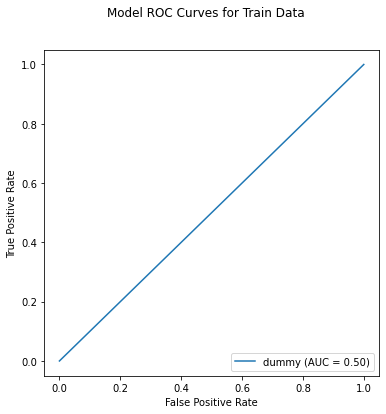

In [26]:
model_dict.plot_models_roc_curves()

In [27]:
model_dict.print_scores('accuracy_score')

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.778112
4,dummy,test,accuracy_score,0.782731


In [28]:
# Step 2
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.
# Upped max iter to get rid of error

fsm_pipe = Pipeline(steps=[('ct', CT),  
                            ('logreg', LogisticRegression(max_iter=1000, random_state=42))])

In [29]:
fsm_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['limit_bal', 'age',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
                                                   'pay_amt3', 'pay_amt4',
                                                   'pay_

In [30]:
fsm_results = SaveModel(model=fsm_pipe, 
                          model_name='fsm',
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)

In [31]:
fsm_results.score_model_train_test()

In [32]:
model_dict.add_model(fsm_results)

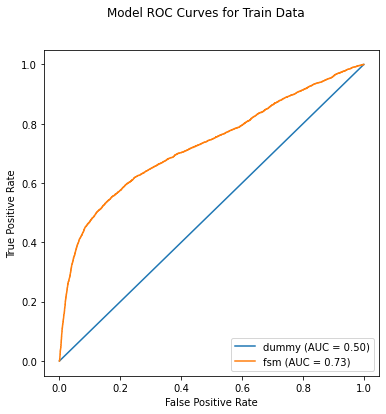

In [33]:
 model_dict.plot_models_roc_curves()

In [34]:
model_dict.print_scores()

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.778112
4,dummy,test,accuracy_score,0.782731
0,fsm,train,accuracy_score,0.813956
4,fsm,test,accuracy_score,0.808635


## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### kNN

In [35]:
knn_pipe = Pipeline([('ct',CT),('knn',KNeighborsClassifier())])

In [36]:
knn_results = SaveModel(model=knn_pipe, 
                          model_name='knn',
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)

In [37]:
knn_results.score_model_train_test()

In [38]:
model_dict.add_model(knn_results)

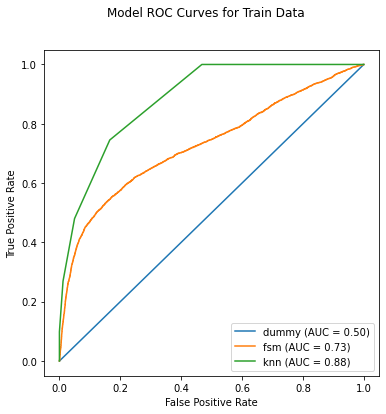

In [39]:
model_dict.plot_models_roc_curves()

In [40]:
model_dict.print_scores('accuracy_score')

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.778112
4,dummy,test,accuracy_score,0.782731
0,fsm,train,accuracy_score,0.813956
4,fsm,test,accuracy_score,0.808635
0,knn,train,accuracy_score,0.845984
4,knn,test,accuracy_score,0.785944


### Decision Tree

In [41]:
dtc = DecisionTreeClassifier(random_state=42)

dtc_pipe = Pipeline([('ct', CT), ('dtc', dtc)])

In [42]:
dtc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['limit_bal', 'age',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
                                                   'pay_amt3', 'pay_amt4',
                                                   'pay_

In [43]:
dtc_results = SaveModel(model=dtc_pipe, 
                          model_name='dtc',
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)

In [44]:
dtc_results.score_model_train_test()

In [45]:
model_dict.add_model(dtc_results)

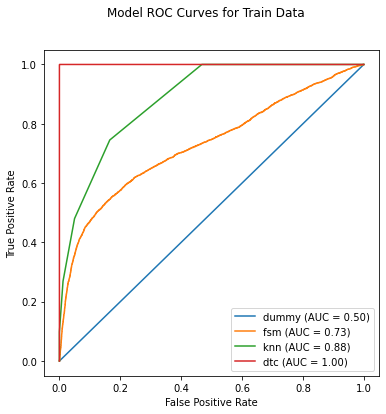

In [46]:
model_dict.plot_models_roc_curves()

In [47]:
model_dict.print_scores()

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.778112
4,dummy,test,accuracy_score,0.782731
0,fsm,train,accuracy_score,0.813956
4,fsm,test,accuracy_score,0.808635
0,knn,train,accuracy_score,0.845984
4,knn,test,accuracy_score,0.785944
0,dtc,train,accuracy_score,0.999649
4,dtc,test,accuracy_score,0.719478


In [48]:
# Instantiate some models

In [49]:
# Must be 'voting=soft' to work with roc

vc = VotingClassifier(estimators=[
    ('lr' , LogisticRegression(max_iter=1000, random_state=42)),
    ('dt' , DecisionTreeClassifier(random_state=42)),
    ('knn' , KNeighborsClassifier())
], verbose=True, voting='soft')

In [50]:
bag = BaggingClassifier(random_state=42, verbose=1)

In [52]:
rf = RandomForestClassifier(random_state=42, verbose=1)

In [53]:
et = ExtraTreesClassifier(bootstrap=True, random_state=42, verbose=1)

In [54]:
sc = StackingClassifier(estimators = [
    ('lr',LogisticRegression(max_iter=1000, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('knn', KNeighborsClassifier()),
    ('bag', BaggingClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
], verbose=1)

In [55]:
model_list = [('voting',vc), ('bagging', bag), ('RandoCalForest',rf), ('ExtraTrees',et), ('stacking',sc)]

In [56]:
# Loop, fit, record.
# This was SHAMELESSLY stolen from Will Bennet from his Phase 3 project.

for name, model in model_list:

    starttime = datetime.now()
    
    print(f'Starting on model: {name}')
    # Create baseline pipelines
    loop_model_pipe = Pipeline(steps=[
        ('ct', CT),
        (name, model)
    ])

    # Create a saved model object
    loop_model_results = SaveModel(model=loop_model_pipe, 
                          model_name=name,
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)
    # Fit and score on train and test data
    loop_model_results.score_model_train_test()

    # Add the model to the dictionary
    model_dict.add_model(loop_model_results)
    
    print(f'{name} took {datetime.now()-starttime} to finish. \n')
    

Starting on model: voting
[Voting] ....................... (1 of 3) Processing lr, total=   0.3s
[Voting] ....................... (2 of 3) Processing dt, total=   0.3s
[Voting] ...................... (3 of 3) Processing knn, total=   0.2s
voting took 0:00:18.613001 to finish. 

Starting on model: bagging


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


bagging took 0:00:02.391000 to finish. 

Starting on model: RandoCalForest


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandoCalForest took 0:00:04.137995 to finish. 

Starting on model: ExtraTrees


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


ExtraTrees took 0:00:01.950971 to finish. 

Starting on model: stacking


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.0s finished


stacking took 0:01:07.694999 to finish. 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


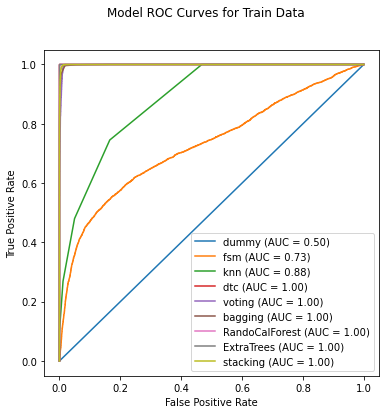

In [57]:
model_dict.plot_models_roc_curves()

In [58]:
model_dict.print_scores('accuracy_score')

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.778112
4,dummy,test,accuracy_score,0.782731
0,fsm,train,accuracy_score,0.813956
4,fsm,test,accuracy_score,0.808635
0,knn,train,accuracy_score,0.845984
4,knn,test,accuracy_score,0.785944
0,dtc,train,accuracy_score,0.999649
4,dtc,test,accuracy_score,0.719478
0,voting,train,accuracy_score,0.939106
4,voting,test,accuracy_score,0.789157


## Tuning and Cross-Validating

In [59]:
rf_pipe = Pipeline([
    ('ct',CT),
    ('rf',rf)
])

In [60]:
rf_pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['limit_bal', 'age',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
                                                   'pay_amt3', 'pay_amt4',
                                                   'pay_

In [68]:
#this stolen shamelessly from here: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(1, 100, num = 21)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1, 100, num = 21)]

# Create the random grid
random_grid = {'rf__n_estimators': n_estimators,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf}

In [69]:
random_grid


{'rf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'rf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'rf__min_samples_split': [1,
  5,
  10,
  15,
  20,
  25,
  30,
  35,
  40,
  45,
  50,
  55,
  60,
  65,
  70,
  75,
  80,
  85,
  90,
  95,
  100],
 'rf__min_samples_leaf': [1,
  5,
  10,
  15,
  20,
  25,
  30,
  35,
  40,
  45,
  50,
  55,
  60,
  65,
  70,
  75,
  80,
  85,
  90,
  95,
  100]}

In [71]:
rgs=RandomizedSearchCV(rf_pipe,
                      random_grid,
                       random_state=42,
                      verbose=1)

In [72]:
# 11min run time!
rgs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   20.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   20.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   19.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.4s finished
[

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dis

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   17.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   17.4s finished
[Parallel(

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 11.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   28.4s finished


RandomizedSearchCV(estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('subpipe_num',
                                                                               Pipeline(steps=[('num_impute',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('ss',
                                                                                                StandardScaler())]),
                                                                               ['limit_bal',
                                                                                'age',
                                                                                'bill_amt1',
                                

In [ ]:
# Saved:
# {'rf__n_estimators': 1200,
#  'rf__min_samples_split': 85,
#  'rf__min_samples_leaf': 40,
#  'rf__max_depth': 20}

In [73]:
rgs.best_params_

{'rf__n_estimators': 1200,
 'rf__min_samples_split': 85,
 'rf__min_samples_leaf': 40,
 'rf__max_depth': 20}

In [ ]:
# rgs_best = rgs.best_estimator_

In [74]:
rgs.score(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    2.3s finished


0.8270582329317269

In [75]:
rgs.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.5s finished


0.8114457831325301

In [76]:
rgs_best=RandomForestClassifier(n_estimators=1200,
                               min_samples_split=85,
                                min_samples_leaf=40,
                                max_depth=20)

In [77]:
rgs_pipe = Pipeline([('ct', CT), ('rgs', rgs_best)])

In [78]:
rgs_results = SaveModel(model=rgs_pipe, 
                          model_name='rgs',
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)

In [79]:
rgs_results.score_model_train_test()

In [80]:
model_dict.add_model(rgs_results)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


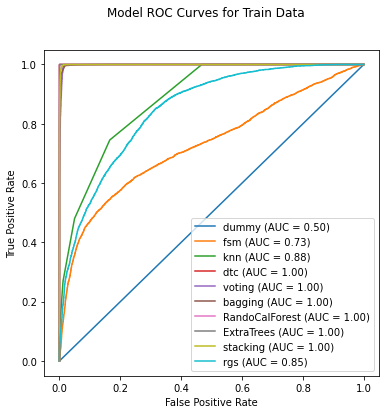

In [81]:
model_dict.plot_models_roc_curves()

In [82]:
model_dict.print_scores('accuracy_score')

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.778112
4,dummy,test,accuracy_score,0.782731
0,fsm,train,accuracy_score,0.813956
4,fsm,test,accuracy_score,0.808635
0,knn,train,accuracy_score,0.845984
4,knn,test,accuracy_score,0.785944
0,dtc,train,accuracy_score,0.999649
4,dtc,test,accuracy_score,0.719478
0,voting,train,accuracy_score,0.939106
4,voting,test,accuracy_score,0.789157


In [83]:
model_dict.validate_models()

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Voting] ....................... (1 of 3) Processing lr, total=   0.4s
[Voting] ....................... (2 of 3) Processing dt, total=   0.4s
[Voting] ...................... (3 of 3) Processing knn, total=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [84]:
model_dict.print_scores('accuracy_score')

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.778112
4,dummy,test,accuracy_score,0.782731
0,fsm,train,accuracy_score,0.813956
4,fsm,test,accuracy_score,0.808635
0,knn,train,accuracy_score,0.845984
4,knn,test,accuracy_score,0.785944
0,dtc,train,accuracy_score,0.999649
4,dtc,test,accuracy_score,0.719478
0,voting,train,accuracy_score,0.939106
4,voting,test,accuracy_score,0.789157


In [ ]:
results_df  = model_dict.return_scores()

In [ ]:
results_df.tail(20)

# `imblearn` Pipelines

## `imblearn` Pipeline

Of course, we want to be able to perform all of our preprocessing steps from above, but just now add `SMOTE`. Good thing we can throw it all into a pipeline!

In [ ]:
imb_pipe = ImPipeline(steps=[('ct', CT),
                             ('sm', SMOTE(random_state=42)),
                            ('rfc', DecisionTreeClassifier(random_state=42))])

In [ ]:
imb_pipe.fit(X_train, y_train)

In [ ]:
imb_pipe.score(X_train, y_train)

## Gridsearching

In [ ]:
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__min_samples_leaf': [1, 5, 10],
          'sm__k_neighbors': [3, 5, 9]}

gs = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=10)

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
gs.best_params_

## Evaluation on Test Set

Let's suppose that we choose our final model from this last GridSearch run. Note that the optimal parameters are also the default values!

In [ ]:
final_model = imb_pipe

In [ ]:
plot_confusion_matrix(final_model, X_test, y_test);

In [ ]:
y_hat = final_model.predict(X_test)

In [ ]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")